In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fetching the data

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", parser="auto")
X, y = mnist.data.to_numpy(), mnist.target.to_numpy()
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

# Visualizing the data

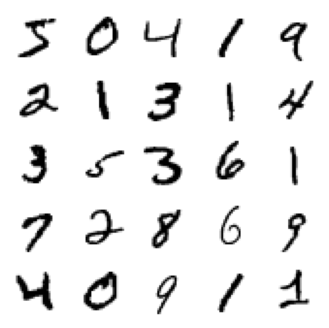

In [5]:
fig, axes = plt.subplots(5, 5, figsize=(4, 4))
for row in range(0, 5):
    for col in range(0, 5):
        axes[row, col].imshow(X[row * 5 + col].reshape((28, 28)), cmap="binary")
        axes[row, col].set_axis_off()

# Stochastic Gradient Descent (SGD) binary classifier of all 5s

In [6]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [7]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
display()

In [8]:
res = sgd_clf.predict(X_train[:25].reshape(25, -1))
np.array(list(map(lambda x: 5 if x else 0, res))).reshape(5, 5)

array([[5, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 5, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

## 3-fold Cross Validation

In [9]:
print("Possible scoring options for cross_validation and cross_val_score:\n")
print(", ".join(sklearn.metrics.get_scorer_names()))

Possible scoring options for cross_validation and cross_val_score:

accuracy, adjusted_mutual_info_score, adjusted_rand_score, average_precision, balanced_accuracy, completeness_score, explained_variance, f1, f1_macro, f1_micro, f1_samples, f1_weighted, fowlkes_mallows_score, homogeneity_score, jaccard, jaccard_macro, jaccard_micro, jaccard_samples, jaccard_weighted, matthews_corrcoef, max_error, mutual_info_score, neg_brier_score, neg_log_loss, neg_mean_absolute_error, neg_mean_absolute_percentage_error, neg_mean_gamma_deviance, neg_mean_poisson_deviance, neg_mean_squared_error, neg_mean_squared_log_error, neg_median_absolute_error, neg_negative_likelihood_ratio, neg_root_mean_squared_error, normalized_mutual_info_score, positive_likelihood_ratio, precision, precision_macro, precision_micro, precision_samples, precision_weighted, r2, rand_score, recall, recall_macro, recall_micro, recall_samples, recall_weighted, roc_auc, roc_auc_ovo, roc_auc_ovo_weighted, roc_auc_ovr, roc_auc_ovr_wei

In [10]:
from sklearn.model_selection import cross_validate
pd.DataFrame(cross_validate(sgd_clf, X_train, y_train_5, cv=3, scoring=["accuracy", "recall", "precision", "positive_likelihood_ratio"]))

,fit_time,score_time,test_accuracy,test_recall,test_precision,test_positive_likelihood_ratio
0,7.108982,0.039798,0.95035,0.470393,0.959368,237.718287
1,6.464208,0.036304,0.96035,0.639734,0.890601,81.962587
2,5.082698,0.031436,0.96040,0.843387,0.749631,30.144866


## Comparing with a dummy classifier

In [11]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

d_clf = DummyClassifier(random_state=42)
d_clf.fit(X_train, y_train_5)
res = d_clf.predict(X_train[:25].reshape(25, -1))
pd.DataFrame(cross_validate(d_clf, X_train, y_train_5, cv=3, scoring="accuracy"))

,fit_time,score_time,test_score
0,0.067249,0.000829,0.90965
1,0.078731,0.001119,0.90965
2,0.065708,0.000893,0.90965


## Calculating the confusion matrix

In [12]:
from sklearn.model_selection import cross_val_predict
# Why do I need to send y_train_5?
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
pd.DataFrame(np.vstack([y_train_5, y_train_pred]).T, columns=["y", "y_hat"])

,y,y_hat
0,True,True
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
59995,False,False
59996,False,False
59997,True,True
59998,False,False


In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score
print("Precision: {}".format(precision_score(y_train_5, y_train_pred)))
print("Recall: {}".format(recall_score(y_train_5, y_train_pred)))
print("F1: {}".format(f1_score(y_train_5, y_train_pred)))

Precision: 0.8370879772350012
Recall: 0.6511713705958311
F1: 0.7325171197343846


## Reporting scores to customize thresholds

In [16]:
sgd_clf.decision_function(X_train[:25]).reshape(5, 5)

array([[  2164.22030239,  -5897.37359354, -13489.14805779,
         -4623.84515943,  -6873.05248453],
       [ -3908.27576291,  -4851.9422397 ,  -4988.52407755,
         -2226.78132866,  -4081.33692831],
       [ -5711.47789687,   4742.52813158, -10322.61970087,
         -5028.5080424 ,  -2774.48933701],
       [ -4757.62175338,  -7995.78737908,  -5478.98084419,
         -2494.25572149,  -8689.98448487],
       [-22773.42525493,   -758.37177086,  -5694.60529267,
         -4975.03617479,  -1371.18472762]])

In [49]:
# Using `decision_function` is the basis for precision / recall tradeoff curve and ROC curve
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [167]:
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(y_train_5, y_scores)
precision_recall_table = pd.DataFrame(dict(threshold=threshold, precision=precision[:-1], recall=recall[:-1]))
precision_recall_table

,threshold,precision,recall
0,-146348.567262,0.090350,1.000000
1,-142300.007054,0.090352,1.000000
2,-137588.975817,0.090353,1.000000
3,-137155.626441,0.090355,1.000000
4,-136254.058562,0.090356,1.000000
...,...,...,...
59995,36801.606970,1.000000,0.000922
59996,37026.251165,1.000000,0.000738
59997,38871.263919,1.000000,0.000553
59998,42216.055628,1.000000,0.000369


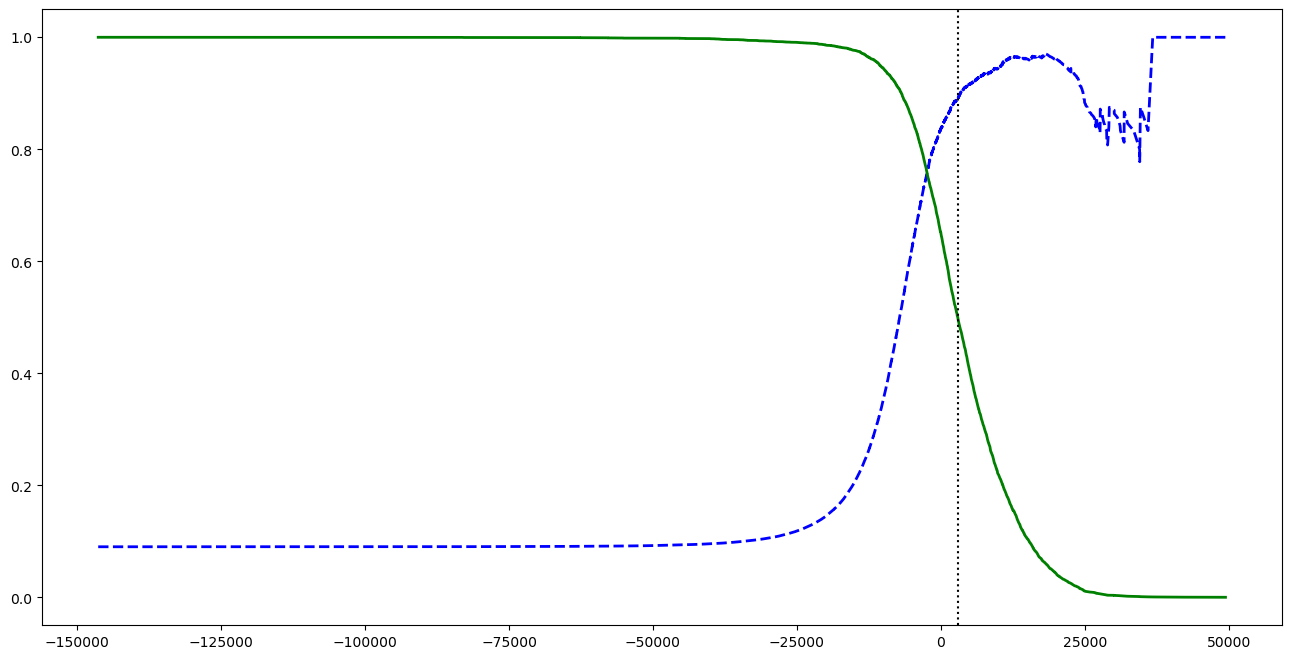

In [168]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(threshold, precision[:-1], "b--", label="Precision", linewidth=2)
ax.plot(threshold, recall[:-1], "g-", label="Recall", linewidth=2)
ax.axvline?
ax.axvline(3000, 0, 1.0, c="k", ls="dotted")
display()

In [232]:
# Finding the score threshold that yields 90% precision
idx_for_90_precision = (precision >= 0.9).argmax()
threshold_for_90_precision = threshold[idx_for_90_precision]
precision_for_90_precision = precision[idx_for_90_precision]
recall_for_90_precision = recall[idx_for_90_precision]
f1_for_90_precision = f1_score(y_train_5, y_scores >= threshold_for_90_precision)
(threshold_for_90_precision, precision_for_90_precision, recall_for_90_precision, f1_for_90_precision)

(3370.019499144183, 0.9000345901072293, 0.4799852425751706, 0.626082771896054)

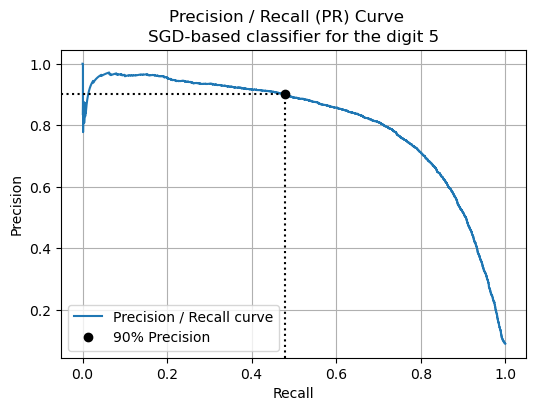

In [170]:
fig, ax = plt.subplots(figsize=(6, 4))
fig.suptitle("Precision / Recall (PR) Curve")
ax.set_title("SGD-based classifier for the digit 5")
ax.plot(recall, precision, label="Precision / Recall curve")
ax.plot(recall_for_90_precision, precision_for_90_precision, "ko", label="90% Precision")
ax.axvline(recall_for_90_precision, ymax=precision_for_90_precision - 0.05, ls=":", c="black")
ax.axhline(precision_for_90_precision, xmax=recall_for_90_precision, ls=":", c="black")
ax.legend(loc="lower left")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.grid()
display()

In [33]:
# Using the threshold to predict
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
print("Precision: {}".format(precision_score(y_train_5, y_train_pred_90)))
print("Recall: {}".format(recall_score(y_train_5, y_train_pred_90)))

Precision: 0.9000345901072293
Recall: 0.4799852425751706


## ROC Curve

In [39]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
roc_data = pd.DataFrame(dict(fpr=fpr, tpr=tpr, thresholds=thresholds))
roc_data

,tpr,fpr,thresholds
0,0.000000,0.000000,49442.437659
1,0.000184,0.000000,49441.437659
2,0.000922,0.000000,36801.606970
3,0.000922,0.000018,35987.203075
4,0.001291,0.000018,34662.209500
...,...,...,...
3903,0.999631,0.997215,-82965.063024
3904,0.999816,0.997215,-83117.290171
3905,0.999816,0.999377,-105763.222401
3906,1.000000,0.999377,-106527.453005


In [56]:
# Note that the thresholds are descending, so we take the first that is smaller
# Remember that in `precision_recall_curve`, we extracted precision and recall and calculated the index
# that yields 90% precision:
#   precision, recall, threshold = precision_recall_curve(y_train_5, y_scores)
#   idx_for_90_precision = (precision >= 0.9).argmax()
#
# However, here we cannot use idx_for_90_precision, because the thresholds yielded by `roc_curve`
# are reversed. So we look it up.
idx_for_threshold_at_90_precision = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90_precision], fpr[idx_for_threshold_at_90_precision]
tpr_90, fpr_90

(0.4799852425751706, 0.005295076861063779)

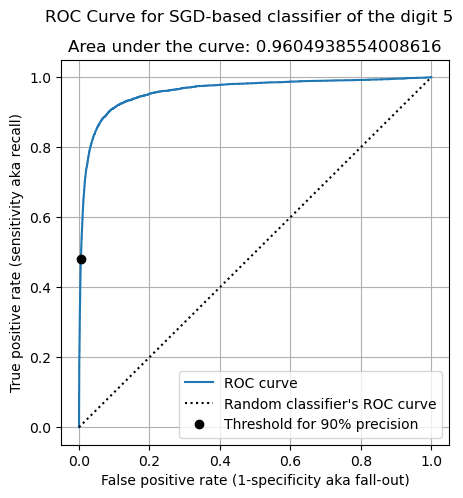

In [181]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_train_5, y_scores)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, label="ROC curve")
ax.plot([0, 1], [0, 1], "k:", label="Random classifier's ROC curve")
ax.plot(fpr_90, tpr_90, "ko", label="Threshold for 90% precision")
ax.grid()
fig.suptitle("ROC Curve for SGD-based classifier of the digit 5")
ax.set_title("Area under the curve: {}".format(auc))
ax.set_xlabel("False positive rate (1-specificity aka fall-out)")
ax.set_ylabel("True positive rate (sensitivity aka recall)")
ax.legend(loc="lower right")
display()

# Random forest classifier

In [116]:
# Similar to `decision_function`, but random forest does not have it. It has `predict_proba` instead.
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [117]:
# These are *estimated* probabilities.
# First column is estimated probability for negative. Second column is for positive.
y_probas_forest

array([[0.11, 0.89],
       [0.98, 0.02],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.93, 0.07]])

In [206]:
y_scores_forest = y_probas_forest[:, 1]
precision_forest, recall_forest, pr_thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)
pd.DataFrame(dict(precision=precision_forest[:-1], recall=recall_forest[:-1], thresholds=pr_thresholds_forest))

,precision,recall,thresholds
0,0.090350,1.000000,0.00
1,0.155978,1.000000,0.01
2,0.217318,1.000000,0.02
3,0.278126,0.999631,0.03
4,0.335542,0.999447,0.04
...,...,...,...
96,1.000000,0.171740,0.96
97,1.000000,0.133370,0.97
98,1.000000,0.093341,0.98
99,1.000000,0.053680,0.99


In [224]:
idx_for_90_precision_forest = (precision_forest >= 0.9).argmax()
threshold_for_90_precision_forest = pr_thresholds_forest[idx_for_90_precision_forest]
precision_for_90_precision_forest = precision_forest[idx_for_90_precision_forest]
recall_for_90_precision_forest = recall_forest[idx_for_90_precision_forest]
f1_for_90_precision_forest = f1_score(y_train_5, y_scores_forest >= threshold_for_90_precision_forest)
(recall_for_90_precision_forest, precision_for_90_precision_forest, f1_for_90_precision_forest)

(0.9719608928242022, 0.9028444139821796, 0.9361286310739985)

In [210]:
# ROC
auc_forest = roc_auc_score(y_train_5, y_scores_forest)
fpr_forest, tpr_forest, roc_thresholds_forest = roc_curve(y_train_5, y_scores_forest)
roc_idx_for_90_precision = (roc_thresholds_forest <= threshold_for_90_precision_forest).argmax()
tpr_90_forest = tpr_forest[roc_idx_for_90_precision]
fpr_90_forest = fpr_forest[roc_idx_for_90_precision]
pd.DataFrame(dict(fpr=fpr_forest, tpr=tpr_forest, thresholds=roc_thresholds_forest))

,fpr,tpr,thresholds
0,0.000000,0.000000,2.00
1,0.000000,0.021767,1.00
2,0.000000,0.053680,0.99
3,0.000000,0.093341,0.98
4,0.000000,0.133370,0.97
...,...,...,...
96,0.196577,0.999447,0.04
97,0.257700,0.999631,0.03
98,0.357720,1.000000,0.02
99,0.537459,1.000000,0.01


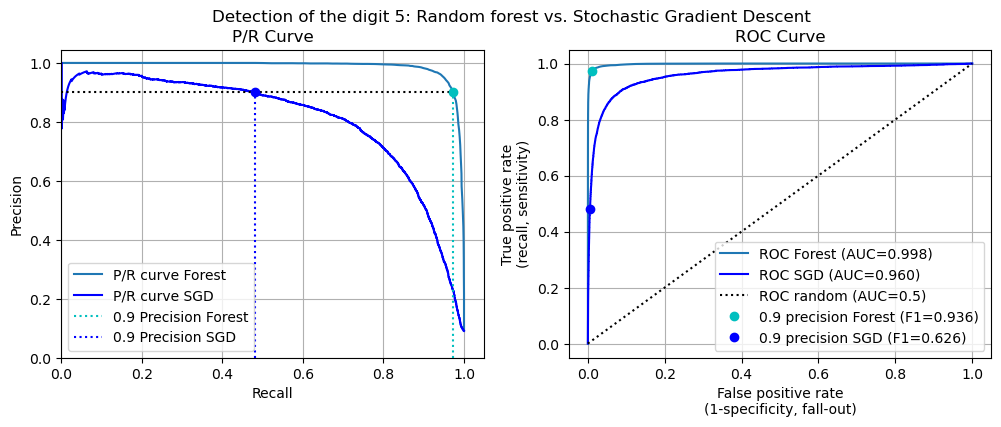

In [233]:
fig, (ax, ax_roc) = plt.subplots(1, 2, figsize=(12, 4))

# P/R curve
ax.plot(recall_forest, precision_forest, label="P/R curve Forest")
ax.plot(recall, precision, "b", label="P/R curve SGD")

fig.suptitle("Detection of the digit 5: Random forest vs. Stochastic Gradient Descent")

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_title("P/R Curve")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.grid()

ax.axvline(recall_for_90_precision_forest, ymax=precision_for_90_precision_forest - 0.05, linestyle=":", c="c", label="0.9 Precision Forest")
ax.axvline(recall_for_90_precision, ymax=precision_for_90_precision - 0.05, linestyle=":", c="b", label="0.9 Precision SGD")
ax.axhline(precision_for_90_precision_forest, xmax=recall_for_90_precision_forest - 0.05, linestyle=":", c="k")
ax.plot(recall_for_90_precision_forest, precision_for_90_precision_forest, "co")
ax.plot(recall_for_90_precision, precision_for_90_precision, "bo")
ax.legend(loc="lower left")

# ROC curve
ax_roc.set_title("ROC Curve")
ax_roc.set_xlabel("False positive rate\n(1-specificity, fall-out)")
ax_roc.set_ylabel("True positive rate\n(recall, sensitivity)")
ax_roc.grid()

ax_roc.plot(fpr_forest, tpr_forest, label="ROC Forest (AUC={:.3f})".format(auc_forest))
ax_roc.plot(fpr, tpr, label="ROC SGD (AUC={:.3f})".format(auc), c="b")
ax_roc.plot([0, 1], [0, 1], "k:", label="ROC random (AUC=0.5)")
ax_roc.plot(fpr_90_forest, tpr_90_forest, "co", label="0.9 precision Forest (F1={:.3f})".format(f1_for_90_precision_forest))
ax_roc.plot(fpr_90, tpr_90, "bo", label="0.9 precision SGD (F1={:.3f})".format(f1_for_90_precision))
ax_roc.legend(loc="lower right")
display()

# Multiclass

## SVC (support vector classification)

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train, y_train)

Scores: 2.74, -0.31, 7.27, 5.22, 4.18, 1.71, 0.71, 8.27, 6.27, 9.31
Decision function shape: ovr
Prediction via predict: 9
Prediction via decision_function: 9


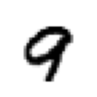

In [351]:
X_random = X_train[5017]
fig, ax = plt.subplots(figsize=(1, 1))
ax.imshow(X_random.reshape(28, 28), cmap="binary")
ax.set_axis_off()

scores = svm_clf.decision_function([X_random])
print("Scores: {}".format(", ".join(["{:.2f}".format(x) for x in scores[0]])))
print("Decision function shape: {}".format(svm_clf.decision_function_shape))
print("Prediction via predict: {}".format(svm_clf.predict([X_random])[0]))
print("Prediction via decision_function: {}".format(svm_clf.classes_[scores.argmax()]))

## SGD

Note: we are rewriting sgd_clf here

In [ ]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

In [358]:
display(sgd_clf.predict([X_random]))
sgd_clf.decision_function([X_random]).round()

array(['9'], dtype='<U1')

array([[-37636., -46740., -13120., -18738., -16078., -15350., -42491.,
         -8571.,     89.,   3670.]])

In [359]:
from sklearn.model_selection import cross_val_score

# Accuracy
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [361]:
# We can do better simply by scaling the inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

In [362]:
sgd_clf.decision_function([X_random]).round()

array([[-37636., -46740., -13120., -18738., -16078., -15350., -42491.,
         -8571.,     89.,   3670.]])

## Analyzing errors in multiclass

In [363]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

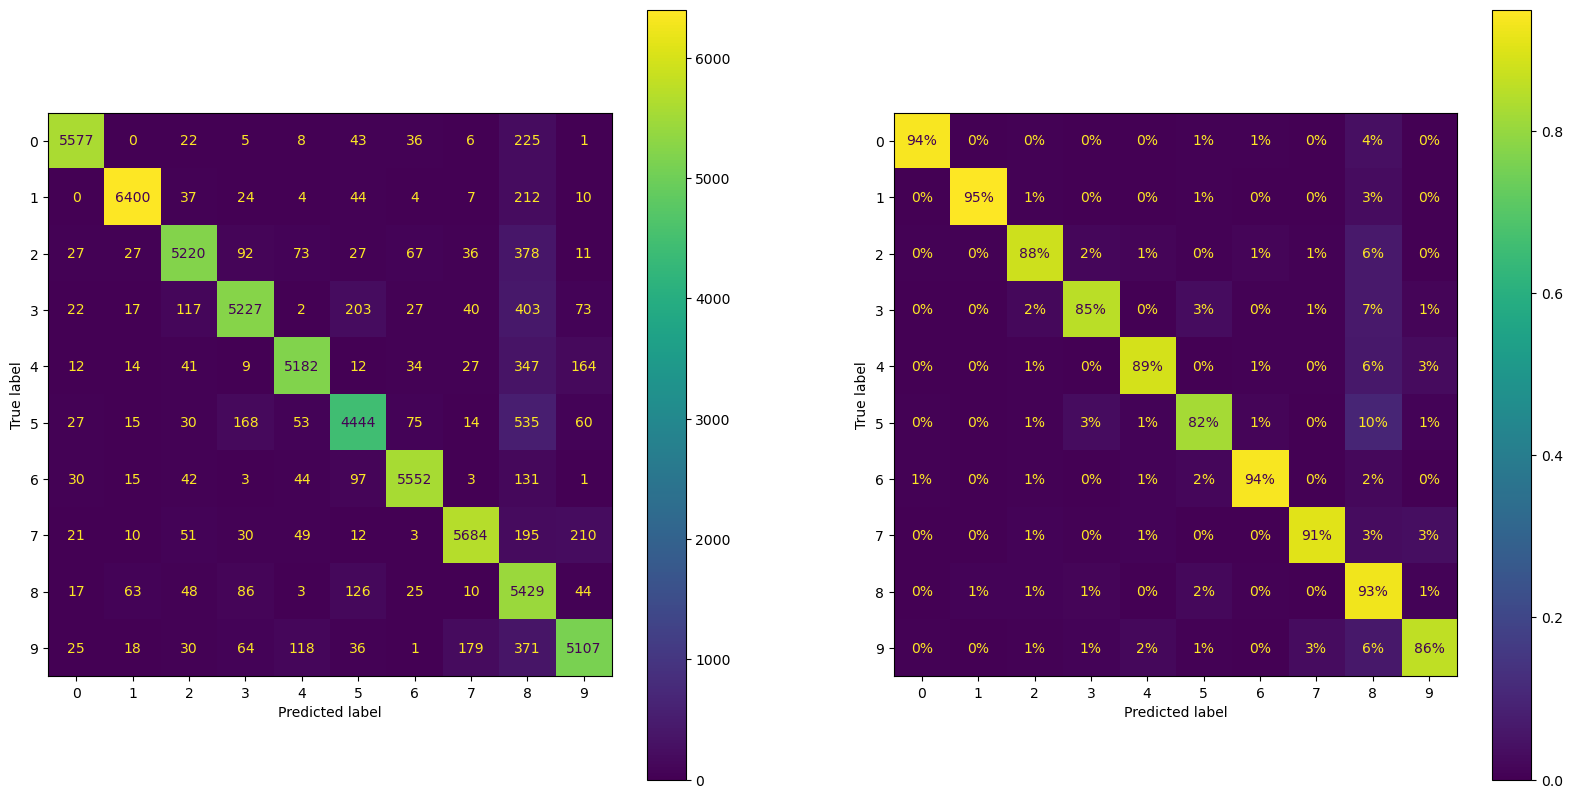

In [371]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=ax1)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=ax2, normalize="true", values_format=".0%")
display()

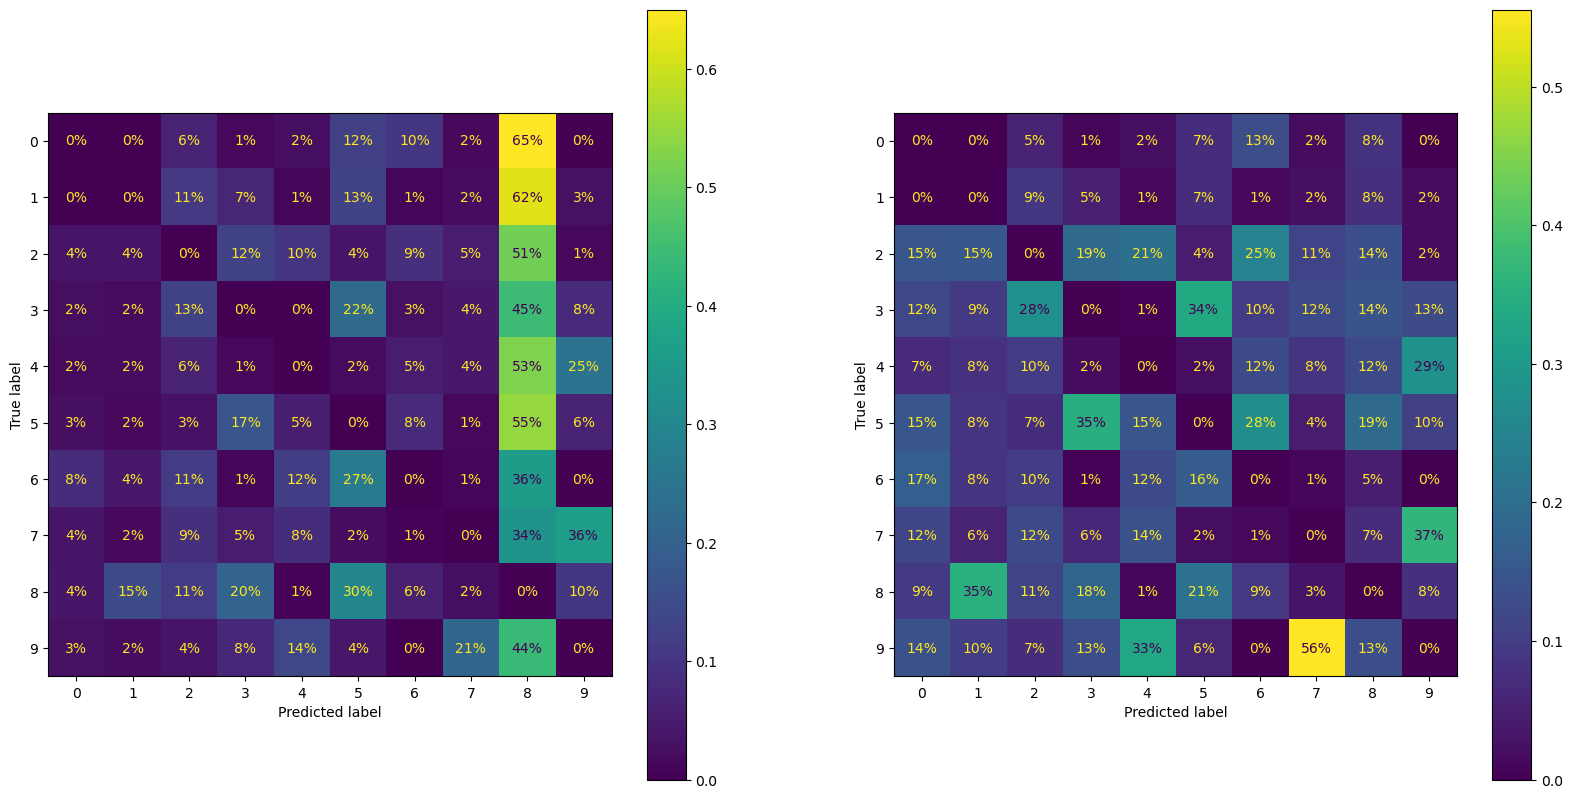

In [377]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

sample_weight = y_train_pred != y_train
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=ax1, normalize="true", values_format=".0%", sample_weight=sample_weight)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=ax2, normalize="pred", values_format=".0%", sample_weight=sample_weight)
display()